# Figure 6:  SMYLE & DPLE Global Sea Level Pressure ACC Maps

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

## Data I/O using Dask

### Create Dask Cluster

In [3]:
cluster.close()
client.close()

In [4]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='P93300313',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client


cluster, client = get_ClusterClient()
cluster.scale(30)

/glade/u/home/tking/anaconda3/envs/esp-lab/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41351 instead
  warnings.warn(


In [5]:
cluster

### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [6]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0, nlead, field):
    """ This preprocessor is applied on an individual timeseries file basis.
    Edit this appropriately for your analysis to speed up processing.
    """
    ds0 = cal.time_set_mid(ds0, 'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon": ds0.lon, "lat": ds0.lat})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [7]:
%%time
# SMYLE-NOV SLP data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 11
smyle11_seas = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle11_seas.nbytes/1e9 #GB

CPU times: user 37.6 s, sys: 16.7 s, total: 54.3 s
Wall time: 1min 22s


3.468172712

In [8]:
%%time
# SMYLE-FEB PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 2
smyle02_seas = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle02_seas.nbytes/1e9 #GB

CPU times: user 37.6 s, sys: 16.7 s, total: 54.3 s
Wall time: 1min 17s


3.468172712

In [9]:
%%time
# SMYLE-MAY PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 5
smyle05_seas = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle05_seas.nbytes/1e9 #GB

CPU times: user 38.1 s, sys: 16.6 s, total: 54.6 s
Wall time: 1min 20s


3.468172712

In [10]:
%%time
# SMYLE-AUG PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 8
smyle08_seas = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle08_seas.nbytes/1e9 #GB

CPU times: user 39.4 s, sys: 16.2 s, total: 55.6 s
Wall time: 1min 18s


3.468172712

In [17]:
%%time
# DPLE-NOV PSL data
# process all 40 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear))
startmonth = 11
dple11_seas = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
dple11_seas.nbytes/1e9 #GB

CPU times: user 24 s, sys: 2.48 s, total: 26.4 s
Wall time: 36 s


6.79478016

### Regrid Hindcast data

In [18]:
# Define 5x5 destgrid
destgrid = xr.Dataset({'lat': np.arange(-90, 95, 5), 'lon': np.arange(0, 360, 5)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny, nx)),  dims=["lat", "lon"], coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny, nx)), dims=["lat", "lon"], coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units': 'degrees_north', 'long_name': 'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units': 'degrees_east', 'long_name': 'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [19]:
dple11_seas = regrid.add_grid_bounds(dple11_seas)
smyle11_seas = regrid.add_grid_bounds(smyle11_seas)
smyle02_seas = regrid.add_grid_bounds(smyle02_seas)
smyle05_seas = regrid.add_grid_bounds(smyle05_seas)
smyle08_seas = regrid.add_grid_bounds(smyle08_seas)

In [20]:
# Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(dple11_seas, destgrid, 'conservative', periodic=True)

In [21]:
%%time
dple11_da = regrid_cam1deg(dple11_seas.PSL).load()

CPU times: user 1min 50s, sys: 4.03 s, total: 1min 54s
Wall time: 2min 1s


In [22]:
%%time
smyle11_da = regrid_cam1deg(smyle11_seas.PSL).load()

CPU times: user 1min 5s, sys: 2.46 s, total: 1min 8s
Wall time: 1min 12s


In [23]:
%%time
smyle02_da = regrid_cam1deg(smyle02_seas.PSL).load()

CPU times: user 1min 3s, sys: 4.29 s, total: 1min 7s
Wall time: 1min 11s


In [24]:
%%time
smyle05_da = regrid_cam1deg(smyle05_seas.PSL).load()

CPU times: user 58.9 s, sys: 5.42 s, total: 1min 4s
Wall time: 1min 11s


In [25]:
%%time
smyle08_da = regrid_cam1deg(smyle08_seas.PSL).load()

CPU times: user 1min, sys: 15 s, total: 1min 15s
Wall time: 1min 24s


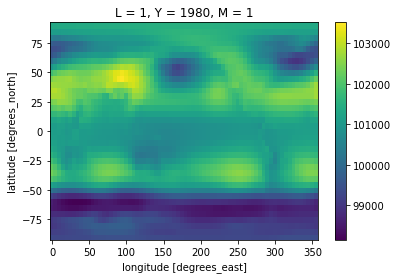

In [26]:
smyle11_da.isel(Y=10, L=0, M=0).plot();

In [27]:
# Save Fig data to file:
outdir = '/glade/u/home/tking/esp_lab_notebook_test/test_data_dir_out/'
ds1 = dple11_da.rename('PSL').to_dataset()
ds1['time'] = dple11_seas.time
ds1.to_netcdf(outdir+'DPLE11_PSL_seas_5x5.nc')

ds1 = smyle11_da.rename('PSL').to_dataset()
ds1['time'] = smyle11_seas.time
ds1.to_netcdf(outdir+'SMYLE11_PSL_seas_5x5.nc')

ds1 = smyle02_da.rename('PSL').to_dataset()
ds1['time'] = smyle02_seas.time
ds1.to_netcdf(outdir+'SMYLE02_PSL_seas_5x5.nc')

ds1 = smyle05_da.rename('PSL').to_dataset()
ds1['time'] = smyle05_seas.time
ds1.to_netcdf(outdir+'SMYLE05_PSL_seas_5x5.nc')

ds1 = smyle08_da.rename('PSL').to_dataset()
ds1['time'] = smyle08_seas.time
ds1.to_netcdf(outdir+'SMYLE08_PSL_seas_5x5.nc')

In [28]:
# Retrieve PSL-saved Fig data:
outdir = '/glade/u/home/tking/esp_lab_notebook_test/test_data_dir_out/'
dple11_seas = xr.open_dataset(outdir+'DPLE11_PSL_seas_5x5.nc')
dple11_da = dple11_seas['PSL']
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_PSL_seas_5x5.nc')
smyle11_da = smyle11_seas['PSL']
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_PSL_seas_5x5.nc')
smyle02_da = smyle02_seas['PSL']
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_PSL_seas_5x5.nc')
smyle05_da = smyle05_seas['PSL']
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_PSL_seas_5x5.nc')
smyle08_da = smyle08_seas['PSL']

### Get SLP OBS

In [29]:
# ERA5  (already on CAM grid)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_era5 = xr.open_dataset(obs_dir+'mon/SLP/SLP_ERA5_oncamgrid_1950_2020.nc', decode_times=False)
era5_montime_vals = [cftime.DatetimeNoLeap(1950+year, 1+month, 15) for year in range(71) for month in range(12)]
ds_era5['time'] = era5_montime_vals
ds_era5 = ds_era5.sel(time=slice("1960", "2020"))

### Compute OBS seasonal averages

In [30]:
def obs_convert_mon_to_seas(da, field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF', 'MAM', 'JJA', 'SON'], dims='season', name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1, 4, 7, 10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist, dim=season)
    return da_seas

In [31]:
era5_seas = obs_convert_mon_to_seas(ds_era5.slp, 'PSL').sel(year=slice("1960", "2020"))
era5_seas = regrid.add_grid_bounds(era5_seas)

In [32]:
era5_seas['lat'] = era5_seas['lat'].assign_attrs({'long_name': 'latitude'})
era5_seas['lon'] = era5_seas['lon'].assign_attrs({'long_name': 'longitude'})

### Regrid OBS

In [33]:
%%time
regrid_era = xe.Regridder(era5_seas, destgrid, 'conservative', periodic=True)
era5_seas_rg = regrid_era(era5_seas.PSL,skipna=True, na_thres=0.9)

CPU times: user 1.62 s, sys: 128 ms, total: 1.75 s
Wall time: 2.04 s


In [34]:
# convert OBS to anomalies from 1972-2017
era5 = era5_seas_rg - era5_seas_rg.sel(year=slice(1972, 2017)).mean('year')

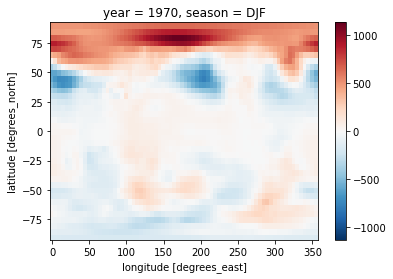

In [35]:
era5.isel(year=10, season=0).plot();

# Anomaly Correlation Plots

In [36]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stats.remove_drift(smyle11_da,smyle11_seas.time,1972,2017)
dple11_anom,dple11_clim = stats.remove_drift(dple11_da,dple11_seas.time,1972,2017)
smyle02_anom,smyle02_clim = stats.remove_drift(smyle02_da,smyle02_seas.time,1972,2017)
smyle05_anom,smyle05_clim = stats.remove_drift(smyle05_da,smyle05_seas.time,1972,2017)
smyle08_anom,smyle08_clim = stats.remove_drift(smyle08_da,smyle08_seas.time,1972,2017)

CPU times: user 1.28 s, sys: 3.7 s, total: 4.98 s
Wall time: 5.22 s


In [37]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stats.leadtime_skill_seas_resamp(dple11_anom,dple11_seas.time,era5,100,20)

CPU times: user 1min 4s, sys: 12.6 s, total: 1min 17s
Wall time: 2min 6s


In [38]:
%%time
smyle11_skill = stats.leadtime_skill_seas(smyle11_anom,smyle11_seas.time,era5)
smyle02_skill = stats.leadtime_skill_seas(smyle02_anom,smyle02_seas.time,era5)
smyle05_skill = stats.leadtime_skill_seas(smyle05_anom,smyle05_seas.time,era5)
smyle08_skill = stats.leadtime_skill_seas(smyle08_anom,smyle08_seas.time,era5)

CPU times: user 2.19 s, sys: 1.84 s, total: 4.03 s
Wall time: 7.75 s


CPU times: user 4.2 s, sys: 14.6 ms, total: 4.22 s
Wall time: 4.34 s


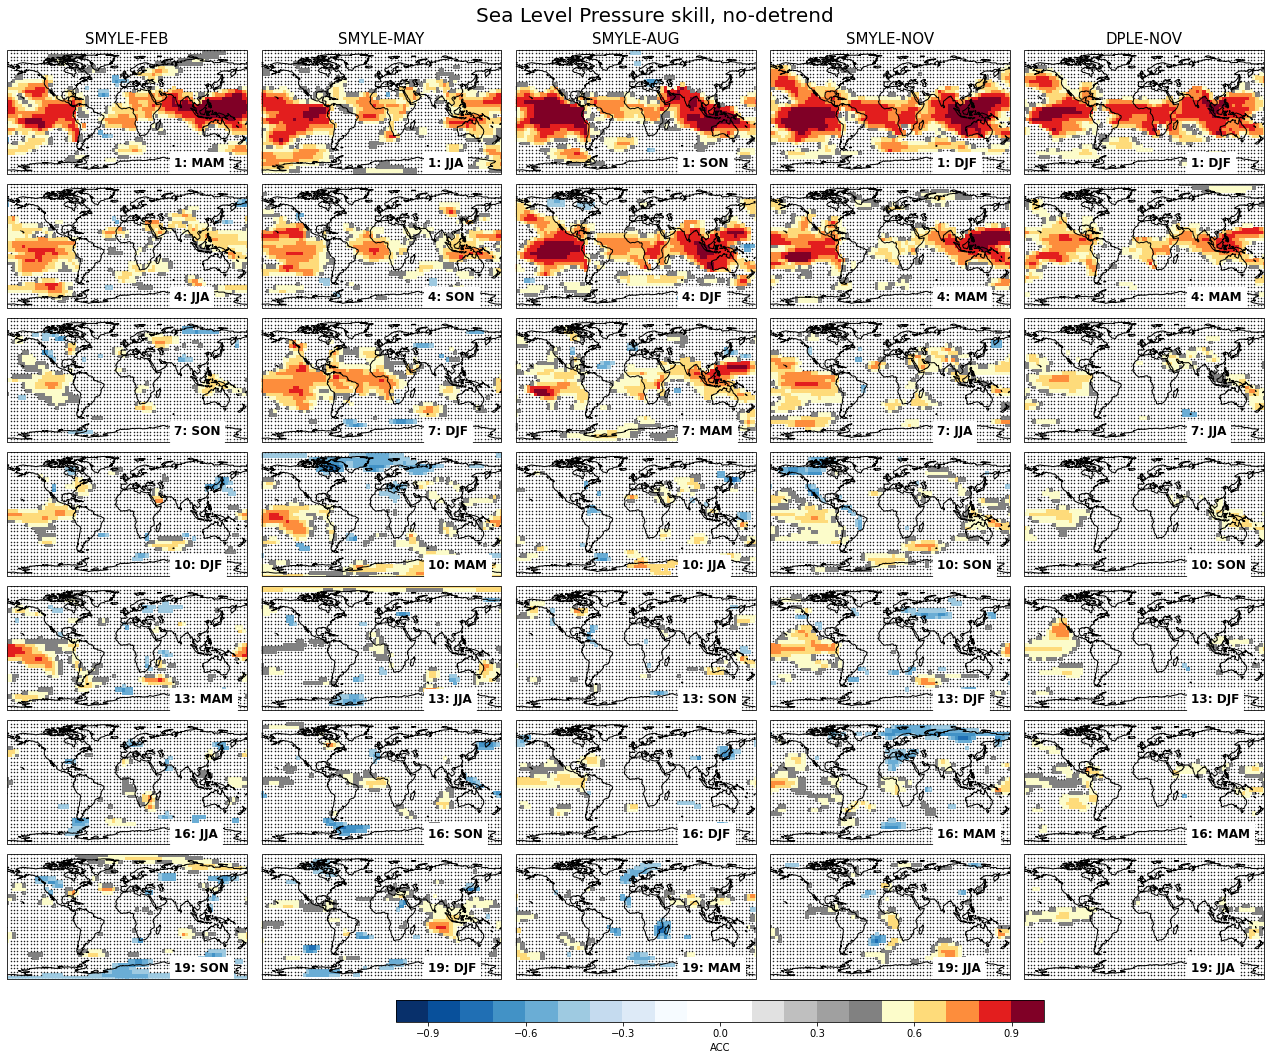

In [68]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax2, smyle05_skill.pval.isel(L=i), smyle05_skill.lon, smyle05_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax3, smyle08_skill.pval.isel(L=i), smyle08_skill.lon, smyle08_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax4, smyle11_skill.pval.isel(L=i), smyle11_skill.lon, smyle11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    maps.map_pvalsig_global_subplot(ax5, dple11_skill.pval.isel(L=i), dple11_skill.lon, dple11_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=1,marker=".")
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Sea Level Pressure skill, no-detrend',fontsize=20)
fig.subplots_adjust(hspace=0.08, wspace=0.06)
fig.subplots_adjust(left=0,right=0.97,bottom=0.08,top=0.94)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
# plt.savefig('Fig06_SLP_ACC_nodetrend.png')

In [40]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_skill['corr'] = dple11_skill.corr.where(dple11_skill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 4.06 s, sys: 13.1 ms, total: 4.07 s
Wall time: 4.25 s


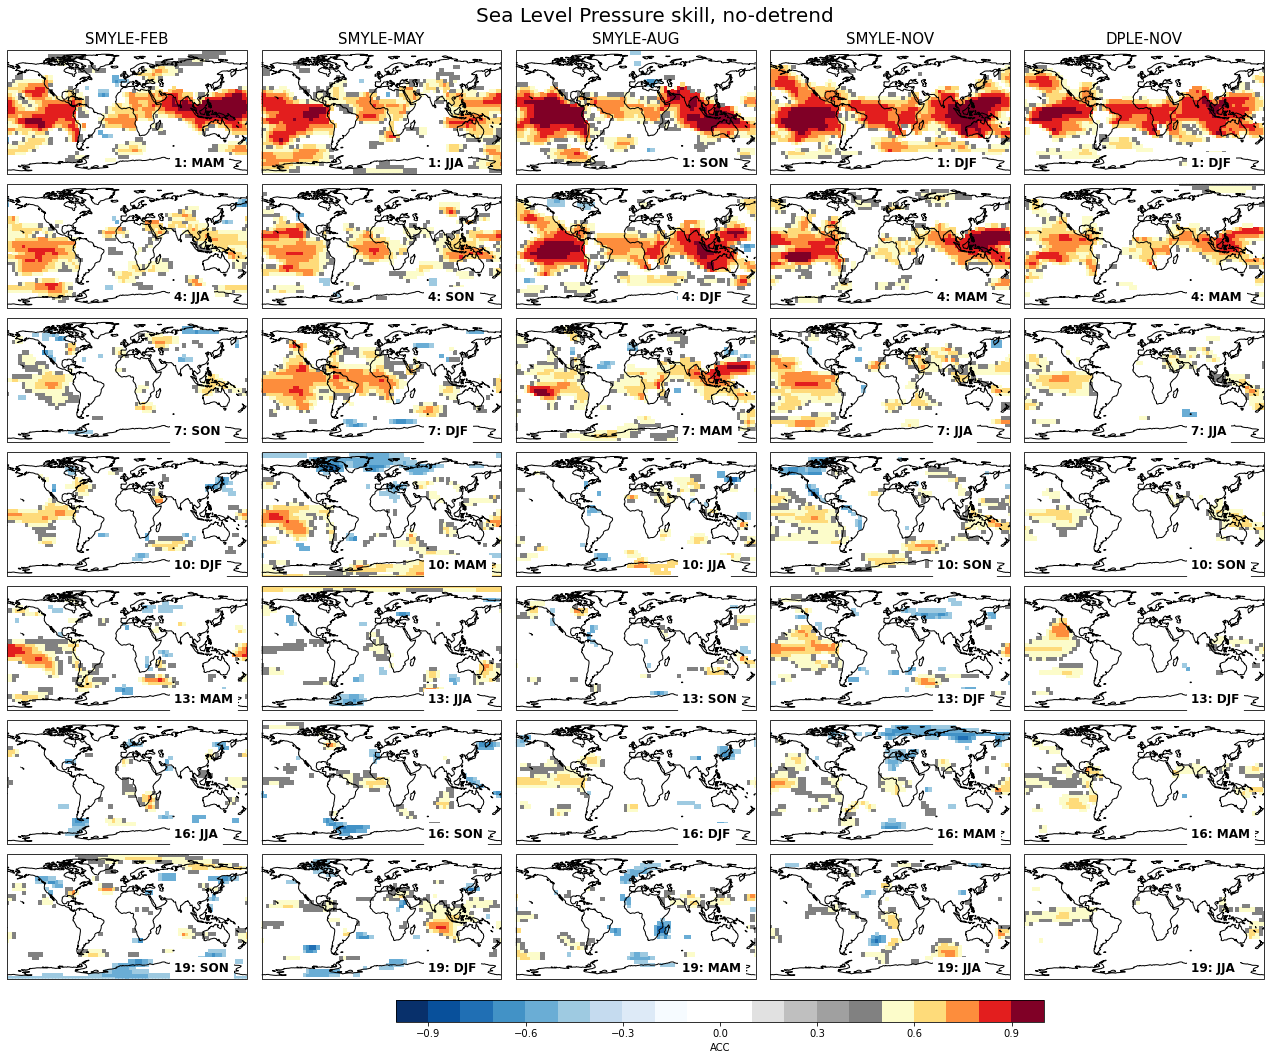

In [67]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Sea Level Pressure skill, no-detrend',fontsize=20)
fig.subplots_adjust(hspace=0.08, wspace=0.06)
fig.subplots_adjust(left=0,right=0.97,bottom=0.08,top=0.94)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
# plt.savefig('Fig06_SLP_ACC_nodetrend.png')

### Test Significance Hatching using correlation p-values

CPU times: user 145 ms, sys: 56 µs, total: 145 ms
Wall time: 146 ms


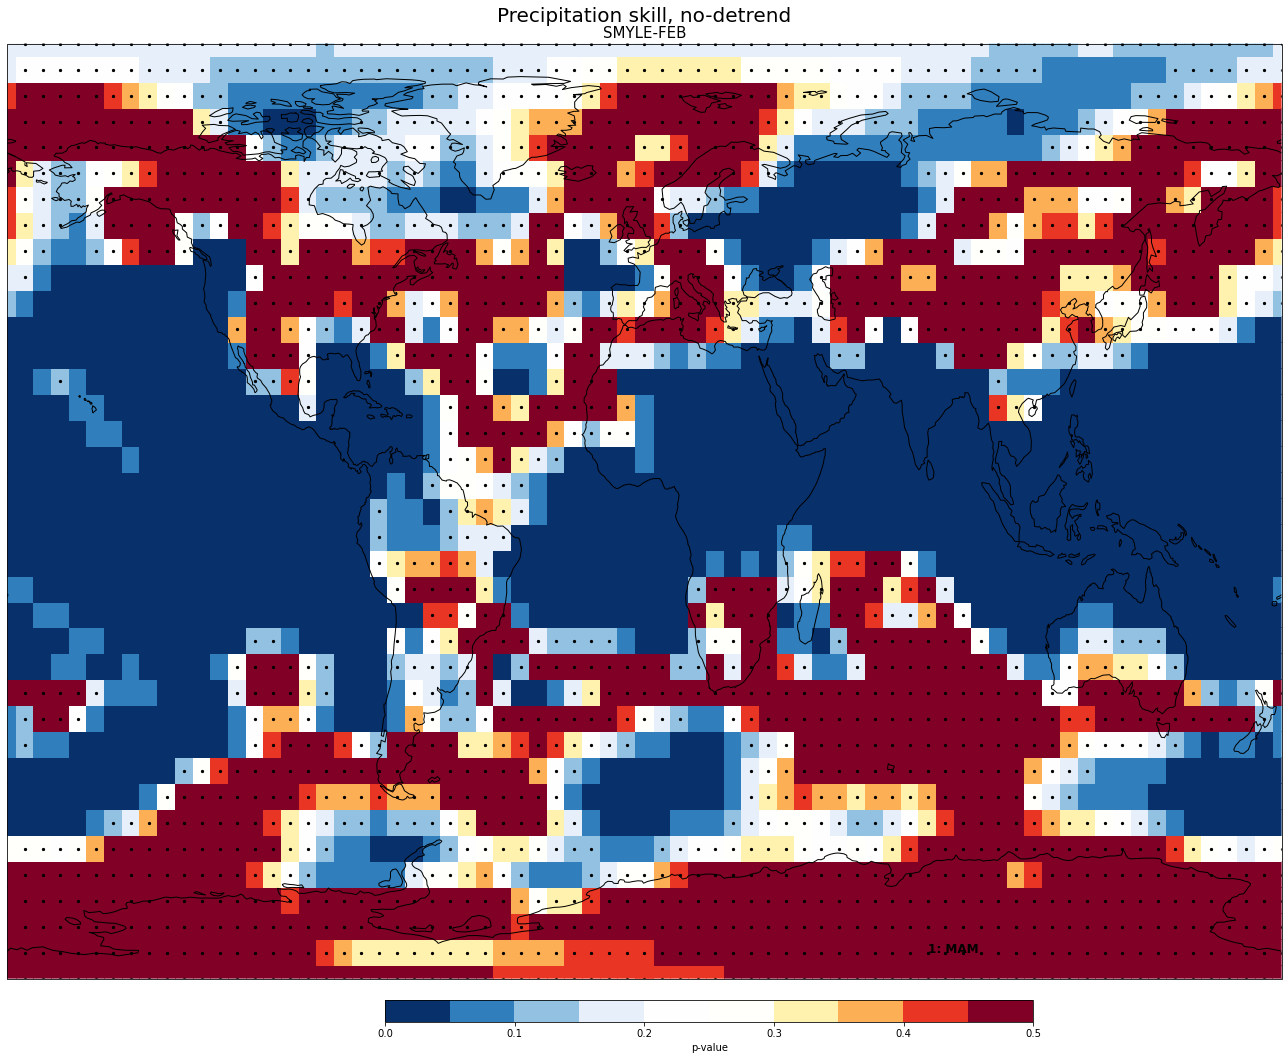

In [66]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj)
    maps.map_pvalsig_global_subplot(ax1, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat, 
                                    siglvl,facecolor='k', edgecolor='k',s=20,marker=".")
    ldstr = str(i+1) + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('Precipitation skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [43]:
%%time
# resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stats.leadtime_skill_seas_resamp(dple11_anom,dple11_seas.time,era5,100,20,detrend=True)

CPU times: user 1min 37s, sys: 12.7 s, total: 1min 50s
Wall time: 3min 3s


In [44]:
%%time
smyle11_skill = stats.leadtime_skill_seas(smyle11_anom,smyle11_seas.time,era5,detrend=True)
smyle02_skill = stats.leadtime_skill_seas(smyle02_anom,smyle02_seas.time,era5,detrend=True)
smyle05_skill = stats.leadtime_skill_seas(smyle05_anom,smyle05_seas.time,era5,detrend=True)
smyle08_skill = stats.leadtime_skill_seas(smyle08_anom,smyle08_seas.time,era5,detrend=True)

CPU times: user 6.44 s, sys: 1.66 s, total: 8.1 s
Wall time: 12.7 s


In [45]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_skill['corr'] = dple11_skill.corr.where(dple11_skill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 6.18 s, sys: 99.7 ms, total: 6.28 s
Wall time: 6.56 s


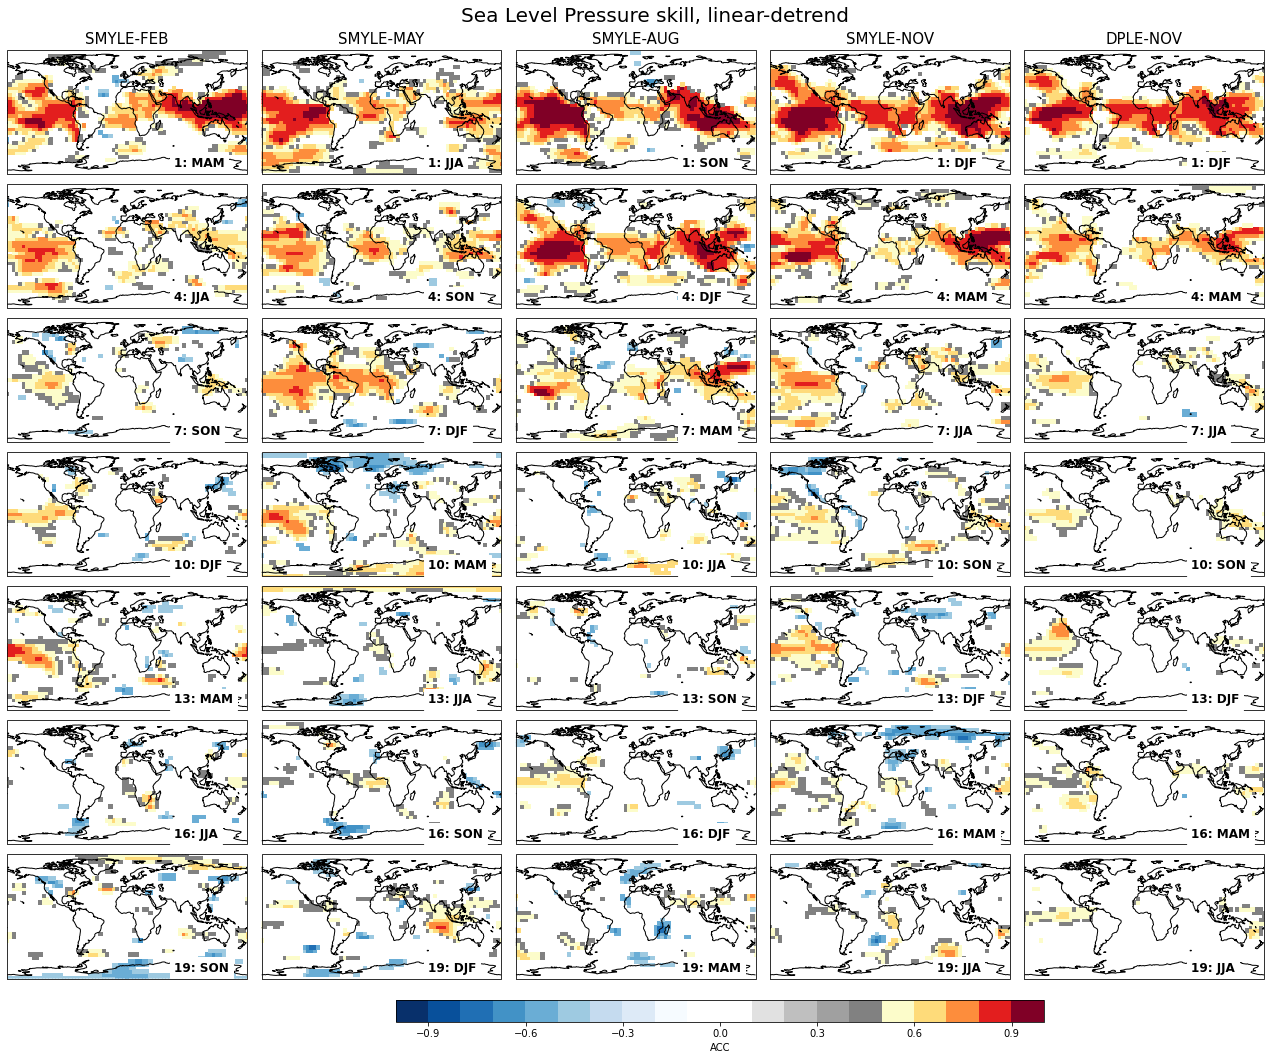

In [65]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -79

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Sea Level Pressure skill, linear-detrend',fontsize=20)
fig.subplots_adjust(hspace=0.08, wspace=0.06)
fig.subplots_adjust(left=0,right=0.97,bottom=0.08,top=0.94)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
# plt.savefig('Fig06_SLP_ACC_lineardetrend.png')

### Look at subsampled skill maps

In [47]:
# This is a list of years for which observed Nino3.4 DJF standardized anomalies exceed +/- 1 std dev. See
# SMYLE-analysis/notebooks/PaperFigs/SMYLEvsDPLE_GlobMaps_SAT.ipynb.
keepyears = np.array([1971, 1973, 1974, 1976, 1983, 1987, 1989, 1992, 1995, 1998, 1999, 2000, 2008, 2010, 2011, 2016])

In [48]:
%%time
keep11 = (keepyears-1)
keep02 = keepyears
keep05 = keepyears
keep08 = (keepyears-1)
smyle11_skill = stats.leadtime_skill_seas(smyle11_anom.sel(Y=keep11),smyle11_seas.time.sel(Y=keep11),era5,detrend=True)
smyle02_skill = stats.leadtime_skill_seas(smyle02_anom.sel(Y=keep02),smyle02_seas.time.sel(Y=keep02),era5,detrend=True)
smyle05_skill = stats.leadtime_skill_seas(smyle05_anom.sel(Y=keep05),smyle05_seas.time.sel(Y=keep05),era5,detrend=True)
smyle08_skill = stats.leadtime_skill_seas(smyle08_anom.sel(Y=keep08),smyle08_seas.time.sel(Y=keep08),era5,detrend=True)

CPU times: user 3.67 s, sys: 387 ms, total: 4.06 s
Wall time: 4.26 s


In [49]:
%%time
## resampled (20-member) skill for DPLE (requires dask cluster!)
dple11_skill = stats.leadtime_skill_seas_resamp(dple11_anom.sel(Y=keep11),dple11_seas.time.sel(Y=keep11),era5,100,20,detrend=True)

CPU times: user 1min 20s, sys: 7.71 s, total: 1min 27s
Wall time: 2min 37s


In [50]:
# Zero out ACC where insignificant
siglvl = 0.1
dple11_skill['corr'] = dple11_skill.corr.where(dple11_skill.pval<siglvl)
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

CPU times: user 4.08 s, sys: 14.5 ms, total: 4.1 s
Wall time: 4.25 s


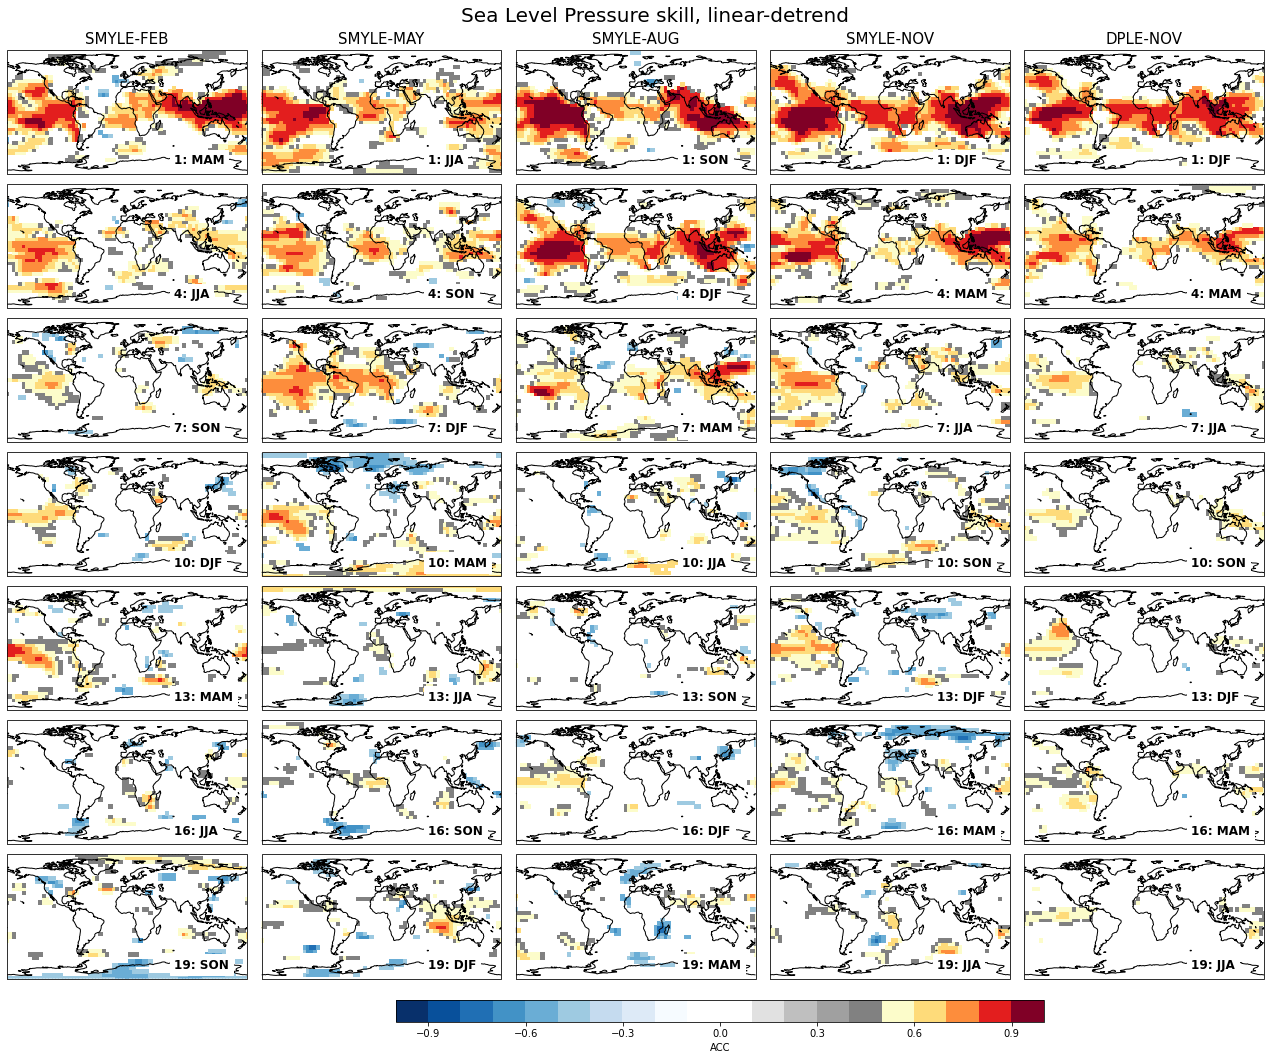

In [64]:
%%time
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
siglvl = 0.1
xloc = 70
yloc = -75

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],nrows,ncols,i*5+1,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax2,cntr2 = maps.map_pcolor_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],nrows,ncols,i*5+2,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax3,cntr3 = maps.map_pcolor_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],nrows,ncols,i*5+3,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],nrows,ncols,i*5+4,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
    
    ax5,cntr5 = maps.map_pcolor_global_subplot(fig, dple11_skill.corr.isel(L=i), dple11_skill.lon, dple11_skill.lat,
                                       ci,cmin,cmax,colstr[4],nrows,ncols,i*5+5,proj,cmap=cmap,cutoff=coff)
    ldstr = ltime[i] + ': ' + str(dple11_skill.isel(L=i).season.values)
    ax5.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')


fig.suptitle('Sea Level Pressure skill, linear-detrend',fontsize=20)
fig.subplots_adjust(hspace=0.08, wspace=0.06)
fig.subplots_adjust(left=0,right=0.97,bottom=0.08,top=0.94)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
# plt.savefig('Fig06_SLP_ACC_lineardetrend_subsamp.png')